# **AREWA DATA SCIENCE ACADEMY**
***Deep Learning Cohort 2.0***

**Name:** Amalai Rham Machunga

**Email:** amachunga@gmail.com

**Title:** Week 3 Solution - PyTorch Neural Network Classification

## **Import required library and set configurations**

In [2]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **Make a binary classification dataset with Scikit-Learn's make_moons() function.**

* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [3]:
# Setup random seed
RANDOM_SEED = 42

In [4]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_moons(n_samples, # samples set to 1000
                  noise=0.03, # add some noise to the data
                  random_state=42) # keep random state so we get the same values

In [5]:
# Turn data into a DataFrame
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


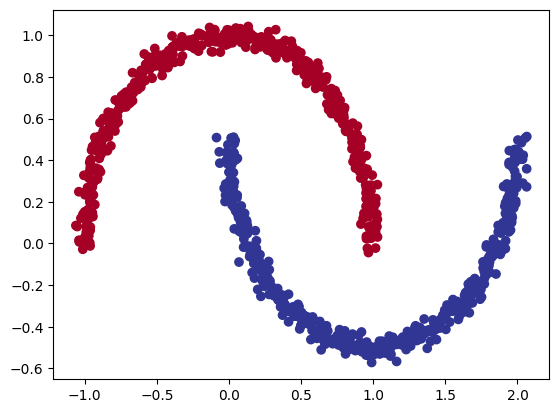

In [6]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [7]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]



(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# **Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data**

In [10]:
# Import the neural network
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()

        self.layer1 = nn.Linear(in_features=in_features,
                                 out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units,
                                 out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units,
                                out_features=out_features)
        self.relu = nn.ReLU()

    # Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer3, a single feature, the same shape as y
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x))))) # computation goes through layer_1 first then the output of layer_1 goes through layer_2, then the output of layer_2 goes through layer_3

# Create an instance of the model and send it to target device
model_0 = MoonModelV0(in_features=2,
                      out_features=1,
                      hidden_units=10).to(device)
model_0

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

# **Setup a binary classification compatible loss function and optimizer to use when training the model**

In [11]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


# **Create a training and testing loop to fit the model to the data created**

* Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
* To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [12]:
# logits (raw outputs of model)
y_logits = model_0(X_test.to(device))[:5] # View the first 5 outputs of the forward pass on the test data
y_logits

tensor([[0.0412],
        [0.0413],
        [0.1308],
        [0.0237],
        [0.1710]], device='cuda:0', grad_fn=<SliceBackward0>)

In [13]:
# Prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5103],
        [0.5103],
        [0.5326],
        [0.5059],
        [0.5426]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [14]:
# Prediction labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [15]:
# Calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

# Use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.5 MB/s eta 0:00:00


MulticlassAccuracy()

In [16]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # Calculate loss
    loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

    # Calculate the Accuracy
    acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

    # Optimizer zero grad i.e Zero the gradients
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass (to get the logits)
        test_logits = model_0(X_test).squeeze()

        # Turn the test logits into prediction labels
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate test loss
        test_loss = loss_fn(test_logits,
                            y_test)
        # Calculate the accuracy
        test_acc = acc_fn(y_test,
                          test_pred)

    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.66348, Accuracy: 0.73% | Test loss: 0.66391, Test acc: 0.69%
Epoch: 100 | Loss: 0.32526, Accuracy: 0.85% | Test loss: 0.33766, Test acc: 0.84%
Epoch: 200 | Loss: 0.22994, Accuracy: 0.89% | Test loss: 0.23023, Test acc: 0.90%
Epoch: 300 | Loss: 0.20405, Accuracy: 0.91% | Test loss: 0.20178, Test acc: 0.92%
Epoch: 400 | Loss: 0.17175, Accuracy: 0.92% | Test loss: 0.16838, Test acc: 0.93%
Epoch: 500 | Loss: 0.12977, Accuracy: 0.94% | Test loss: 0.12504, Test acc: 0.95%
Epoch: 600 | Loss: 0.08605, Accuracy: 0.97% | Test loss: 0.08079, Test acc: 0.98%
Epoch: 700 | Loss: 0.05374, Accuracy: 0.99% | Test loss: 0.04910, Test acc: 1.00%
Epoch: 800 | Loss: 0.03485, Accuracy: 1.00% | Test loss: 0.03109, Test acc: 1.00%
Epoch: 900 | Loss: 0.02427, Accuracy: 1.00% | Test loss: 0.02131, Test acc: 1.00%


# **Make predictions with your trained model and plot them using the plot_decision_boundary() function**

In [17]:
# Plot the model predictions

import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

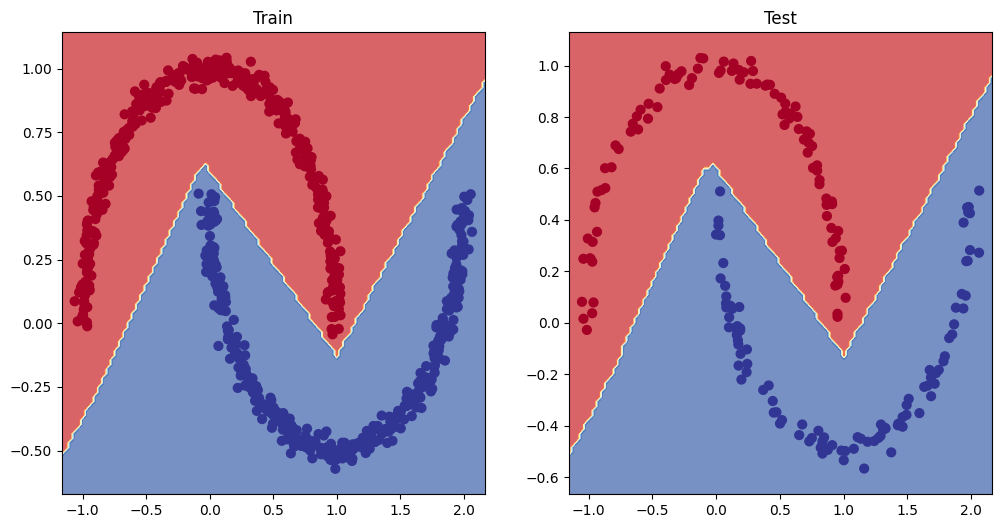

In [18]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# **Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.**

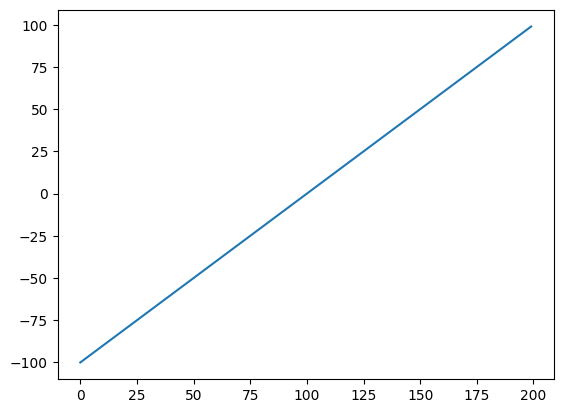

In [20]:
tensor_A = torch.arange(-100, 100, 1)
plt.plot(tensor_A)
plt.show()

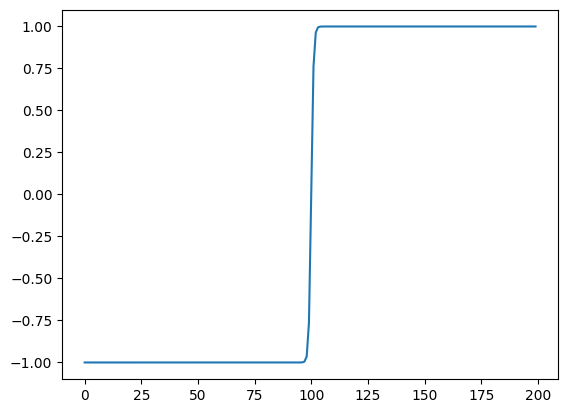

In [21]:
plt.plot(torch.tanh(tensor_A))
plt.show()

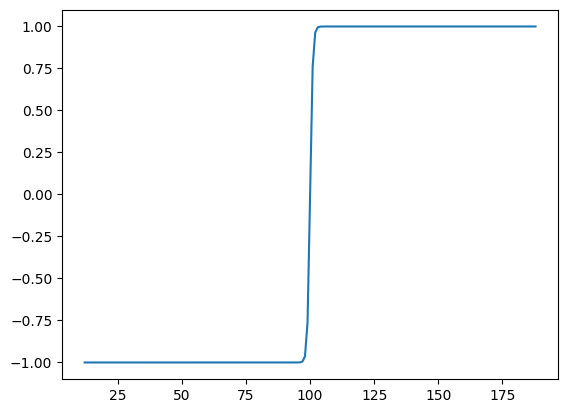

In [23]:
def tanh(x):
  # Source - https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(tanh(tensor_A))
plt.show()

# **Create a multi-class dataset using the spirals data creation function using [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/)**

* Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

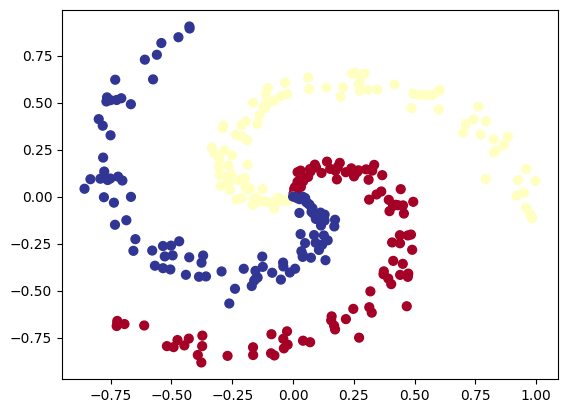

In [28]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [29]:
## Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [30]:
# Calculuate the accuracy for when we fit our model
from torchmetrics import Accuracy

# Send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [31]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = SpiralModel().to(device)
model_1

SpiralModel(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [32]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))

torch.float32 torch.float32 torch.int64 torch.int64
Logits:
tensor([[-0.2160, -0.0600,  0.2256],
        [-0.2020, -0.0530,  0.2257],
        [-0.2223, -0.0604,  0.2384],
        [-0.2174, -0.0555,  0.2826],
        [-0.2201, -0.0502,  0.2792],
        [-0.2195, -0.0565,  0.2457],
        [-0.2212, -0.0581,  0.2440],
        [-0.2251, -0.0631,  0.2354],
        [-0.2116, -0.0548,  0.2336],
        [-0.2170, -0.0552,  0.2842]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.2685, 0.3139, 0.4176],
        [0.2707, 0.3142, 0.4151],
        [0.2659, 0.3126, 0.4215],
        [0.2615, 0.3074, 0.4311],
        [0.2609, 0.3092, 0.4299],
        [0.2653, 0.3123, 0.4224],
        [0.2653, 0.3123, 0.4224],
        [0.2659, 0.3127, 0.4214],
        [0.2681, 0.3136, 0.4184],
        [0.2614, 0.3072, 0.4314]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')


In [33]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.02)

In [34]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.12 Acc: 0.32 | Test loss: 1.10 Test acc: 0.37
Epoch: 100 | Loss: 0.45 Acc: 0.78 | Test loss: 0.53 Test acc: 0.68
Epoch: 200 | Loss: 0.12 Acc: 0.96 | Test loss: 0.09 Test acc: 0.98
Epoch: 300 | Loss: 0.07 Acc: 0.98 | Test loss: 0.02 Test acc: 1.00
Epoch: 400 | Loss: 0.05 Acc: 0.98 | Test loss: 0.01 Test acc: 1.00
Epoch: 500 | Loss: 0.04 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 600 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 700 | Loss: 0.03 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00


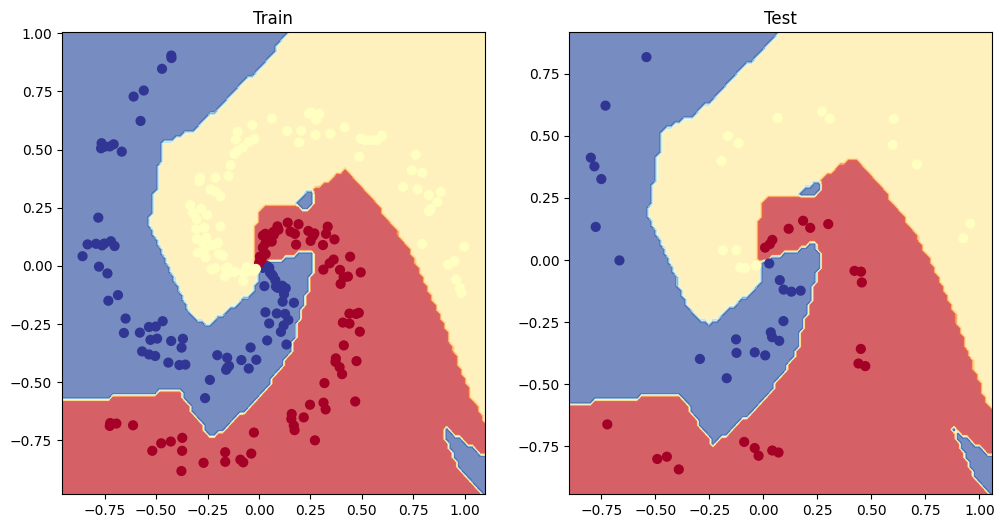

In [35]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)